# **Predicting house prices: A regression example**
## **The Boston Housing Price dataset**

In [17]:
import numpy as np
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import RMSprop

In [27]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [28]:
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (404, 13)
Test data shape: (102, 13)


In [29]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

## **Normalizing the data**

In [33]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data -= mean
train_data /= std
test_data -= mean
test_data /= std

## **Model definition**

In [34]:
def build_model():
    model = Sequential([
        Input(shape=(train_data.shape[1],)),  # Define input shape here
        Dense(64, activation="relu"),
        Dense(64, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer=RMSprop(), loss="mse", metrics=["mae"])
    return model

###  **Validating your approach using K-fold validation**

In [35]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

print("All scores:", all_scores)


Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
All scores: [2.0912320613861084, 2.3437840938568115, 2.5886831283569336, 2.5081217288970947]


In [36]:
all_scores

[2.0912320613861084,
 2.3437840938568115,
 2.5886831283569336,
 2.5081217288970947]

In [37]:
np.mean(all_scores)

2.382955253124237

### **Saving the validation logs at each fold**

In [38]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


## **Building the history of successive mean K-fold validation scores**

In [39]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

## **Plotting validation scores**

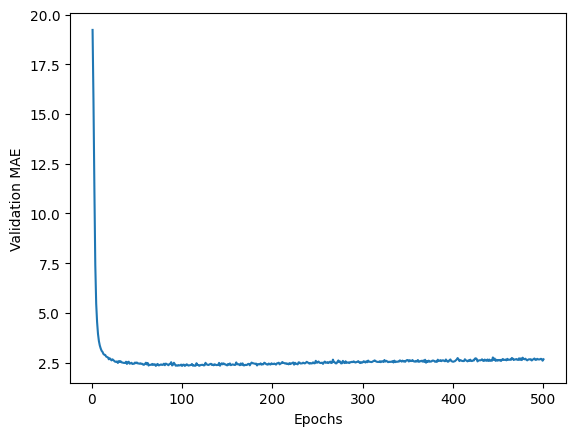

In [41]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

### **Plotting validation scores, excluding the first 10 data points**

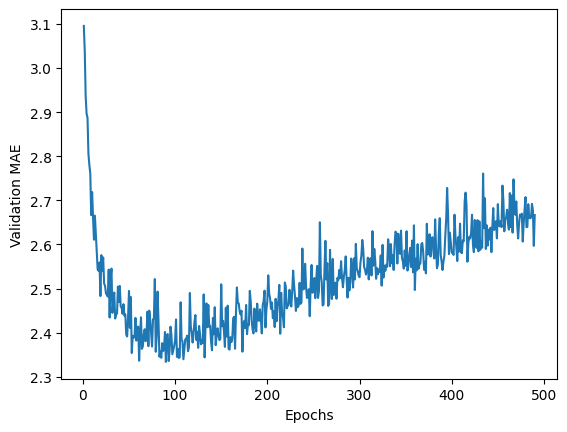

In [42]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

## **Training the final model**

In [43]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.5215 - mae: 2.9594  


In [ ]:
test_mae_score

## **predictions on new data**

In [48]:
from sklearn.metrics import mean_squared_error

predictions = model.predict(test_data)
mse = mean_squared_error(test_targets, predictions)
print("Mean Squared Error (MSE):", mse)
print("Sample prediction:", predictions[0])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Squared Error (MSE): 19.27959404950536
Sample prediction: [11.430085]
